In [31]:
import argparse
import os
import math
import numpy as np
import random
import struct
import matplotlib.pyplot as plt

In [32]:
class GillespieSelectionSimulation:
    def __init__(self, L, N, s, migration_matrix, tfinal, seed=None, l0=0):
        assert len(migration_matrix) == L, "Migration matrix size must match the number of demes"
        for j in range(L):
            assert len(migration_matrix[j]) == L, "Migration matrix must be square"
            assert migration_matrix[j][j] == 0, "Diagonal elements must be 0"
        
        self.L = L
        self.N = N
        self.s = s
        self.migration_matrix = migration_matrix
        self.tfinal = tfinal
        self.l0 = l0
        np.random.seed(seed)  # Setting the random seed

        print('Initialization complete. Seed:', seed)

    def simulate(self):
        t = 0
        mutants = np.zeros(self.L)
        # mutants[self.l0] = 1
        mutants = mutants + 1
        events = []

        mut_traj = [[t, mutants.copy()]]  # Initialize with the starting state

        print("Starting simulation...")
        while t < self.tfinal:
            if np.sum(mutants) == 0:
                print(f"All mutants extinct at time {t}. Reintroducing...")
                mutants[self.l0] = 1
                t = 0
                events = []
                mut_traj = [[t, mutants.copy()]]

            # wild_type = self.N - mutants
            f = mutants / self.N

            rate_mutant_replaces_wt = self.N * f * (1 - f) * (1 + self.s)
            rate_wt_replaces_mutant = self.N * f * (1 - f)
            total_rate = np.sum(rate_mutant_replaces_wt + rate_wt_replaces_mutant)

            if total_rate == 0:
                print("No possible reactions. Skipping...")
                break

            tau = np.random.exponential(scale=1 / total_rate)
            t += tau

            reaction_probabilities = np.concatenate((rate_mutant_replaces_wt, rate_wt_replaces_mutant)) / total_rate
            cumulative_prob = np.cumsum(reaction_probabilities)
            r = np.random.rand()
            reaction_index = np.where(cumulative_prob > r)[0][0]

            if reaction_index < self.L:
                event_type = 'M->W'
                deme_update = reaction_index
                parent_deme = deme_update
                mutants[reaction_index] += 1
            else:
                event_type = 'W->M'
                deme_update = reaction_index - self.L
                parent_deme = deme_update
                mutants[parent_deme] -= 1


            mut_traj.append([t, mutants.copy()])
            events.append([t, deme_update, event_type, parent_deme])
            
            # if np.sum(mutants) == self.N*self.L:
            #     print(f"Mutant_traj: {mut_traj}")
            #     break

        return events, mut_traj

In [33]:
def plot_mutant_trajectories(mut_traj, L):
    times = [state[0] for state in mut_traj]
    mutant_counts = [state[1] for state in mut_traj]
    plt.figure(figsize=(10, 6))
    for deme in range(L):
        plt.plot(times, [m[deme] for m in mutant_counts], label=f'Deme {deme+1}')
    plt.xlabel('Time')
    plt.ylabel('Number of Mutants')
    plt.title('Mutant Trajectories Over Time')
    plt.legend()
    plt.show()


Initialization complete. Seed: None
Starting simulation...
No possible reactions. Skipping...
[0.003424088155467791, 8, 'M->W', 8]
[0.07934015003745558, 0, 'M->W', 0]
[0.09749306140756434, 9, 'M->W', 9]
[0.10773673658804024, 0, 'M->W', 0]
[0.12093939567113267, 3, 'W->M', 3]
[0.12325808619170923, 7, 'W->M', 7]
[0.21699142150915285, 8, 'W->M', 8]
[0.2266884950671264, 4, 'M->W', 4]
[0.23171279036079073, 2, 'M->W', 2]
[0.27964923438937117, 9, 'M->W', 9]
[0.4434984532405069, 0, 'M->W', 0]
[0.5106160316150608, 9, 'M->W', 9]
[0.5111606362930142, 0, 'M->W', 0]
[0.5402453129417968, 9, 'W->M', 9]
[0.5492292545373914, 4, 'M->W', 4]
[0.5581701961606316, 4, 'M->W', 4]
[0.610985202231382, 8, 'M->W', 8]
[0.6482759139154726, 6, 'M->W', 6]
[0.6612399093542674, 4, 'M->W', 4]
[0.6642879285572872, 8, 'M->W', 8]
[0.6675103600761575, 9, 'W->M', 9]
[0.6847636694146536, 1, 'W->M', 1]
[0.74033834139546, 6, 'M->W', 6]
[0.7641137825266734, 8, 'M->W', 8]
[0.7821920548638129, 6, 'M->W', 6]
[0.787275202722917, 0, '

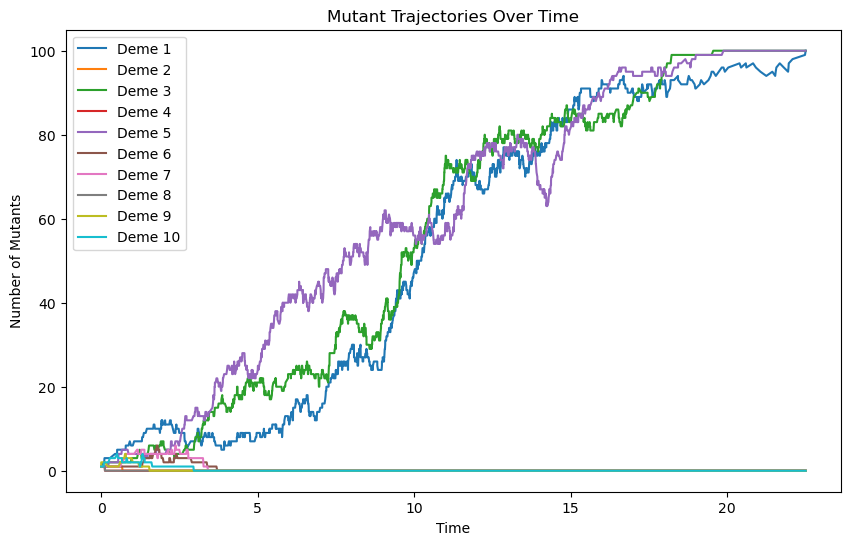

In [34]:
# Example usage
L = 10  # Number of demes
N = 100  # Population per deme
s = 0.25  # Selection coefficient
migration_matrix = np.zeros((L, L))  # Example migration matrix
tfinal = 100  # Simulation time limit
simulation = GillespieSelectionSimulation(L, N, s, migration_matrix, tfinal)
events, mut_traj = simulation.simulate()
for event in events:
    print(event)  # Print each event
plot_mutant_trajectories(mut_traj, L)


In [35]:

class MigrationMatrixGenerator:
    def __init__(self, deme_dimension, migration_rate):
        self.deme_dimension = deme_dimension
        self.migration_rate = migration_rate
    

    def generate_1Dmatrix(self):
        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            if i > 0:
                M[i, i - 1] = self.migration_rate
            if i < self.deme_dimension - 1:
                M[i, i + 1] = self.migration_rate

        return M
    
    
    def generate_2Dmatrix(self):
        """
        Generates a 2D migration matrix for a square grid of demes.
        Each deme can migrate to its immediate neighbors (up, down, left, right).
        Diagonal elements are set to 0, indicating no self-migration.
        """
        z = math.sqrt(self.deme_dimension)
        if not z.is_integer():
            raise ValueError("Deme dimension must be a perfect square for a 2D grid.")
        z = int(z)

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            for j in range(self.deme_dimension):
                # Check for right neighbor
                if j == i + 1 and (i + 1) % z != 0:
                    M[i, j] = self.migration_rate
                # Check for down neighbor
                elif j == i + z and j < self.deme_dimension:
                    M[i, j] = self.migration_rate

                # Ensure migration is bidirectional
                M[j, i] = M[i, j]

        return M

    def generate_3Dmatrix(self):
        """
        Generates a 3D migration matrix for a cubic grid of demes.
        Each deme can migrate to its immediate neighbors along the x, y, and z axes.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        cube_root = round(self.deme_dimension ** (1/3))
        if cube_root ** 3 != self.deme_dimension:
            raise ValueError("Deme dimension must be a cube number for a 3D grid.")

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            x, y, z = np.unravel_index(i, (cube_root, cube_root, cube_root))

            # Check neighbors in each direction (left, right, up, down, front, back)
            for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                nx, ny, nz = x + dx, y + dy, z + dz
                if 0 <= nx < cube_root and 0 <= ny < cube_root and 0 <= nz < cube_root:
                    neighbor_index = np.ravel_multi_index((nx, ny, nz), (cube_root, cube_root, cube_root))
                    M[i, neighbor_index] = self.migration_rate

        return M

    def generate_island_model_matrix(self):
        """
        Generates a migration matrix based on the island model.
        Each deme has an equal migration rate to every other deme.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        M = np.full((self.deme_dimension, self.deme_dimension), self.migration_rate)
        np.fill_diagonal(M, 0)  # Set diagonal elements to 0
        return M    

In [36]:
class DeterministicTrajectorySimulator:
    def __init__(self, L, N, frequencies):
        self.L = int(L)
        self.N = N
        self.frequencies = frequencies
        if len(frequencies) % L != 0:
            raise ValueError("Length of frequencies must be a multiple of the number of demes (L)")
        self.end_time = len(frequencies) // L
        self.timestep = 1 * self.N  #in generations
        # Initialize the attributes to store simulation results
        self.simulated_time = []
        self.simulated_allele_freqs = []
        # self.timecount = 0

    def simulate(self):
        self.simulated_time = []  # Resetting in case simulate is called multiple times
        self.simulated_allele_freqs = []  # Resetting as well
        forwards_t = 0
        backwards_t = 0
        position = len(self.frequencies) - self.L

        while forwards_t < self.end_time:
            # self.timecount += 1
            timestep_freqs = self.frequencies[position:position+self.L]
            self.simulated_allele_freqs.append(timestep_freqs)
            self.simulated_time.append(backwards_t)
            forwards_t += 1
            backwards_t += self.timestep
            position -= self.L
        return self.simulated_time, self.simulated_allele_freqs

        # No need to return since we're setting the attributes directly


    # def write_results_to_file(self, filename="simulation_results.bin"):
    #     with open(filename, 'wb') as file:
    #         # Write the number of demes (L) as a double
    #         file.write(struct.pack('d', float(self.L)))
    #         # Write the total number of timesteps as a double
    #         file.write(struct.pack('d', float(len(self.simulated_time))))
            
    #         # Write each timestep's data as doubles, including the time
    #         for t, freqs in zip(self.simulated_time, self.simulated_allele_freqs):
    #             # Pack and write the time as a double
    #             file.write(struct.pack('d', float(t)))
    #             # Then write the frequencies for this timestep as doubles
    #             for freq in freqs:
    #                 # Convert freqs to doubles and write
    #                 file.write(struct.pack('d', float(freq)))
